# Setup

In [120]:
import pandas as pd
import matplotlib.pyplot as plt
from utils.functions import *
from nltk.corpus import stopwords
from tqdm import tqdm
import re
import nltk
from nltk import word_tokenize
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
import streamlit as st

In [31]:
df = pd.read_csv('../data/data.csv', index_col=0)

In [2]:
df = pd.read_csv('../data/data_polarity.csv', index_col=0)

# Preprocessing

In [52]:
# nltk stopwords
stopwords = stopwords.words('english')

In [53]:
# remove missing values
df.dropna(inplace=True)

In [55]:
# Step 1: Lowercasing
df['title'] = df['title'].str.lower()

# Step 2: Removing Punctuation, Numbers, and Special Characters
df['title'] = df['title'].apply(lambda x: re.sub(r'\d+', '', x))
df['title'] = df['title'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

# Step 3: Tokenization
df['title'] = df['title'].apply(nltk.word_tokenize)

# Step 4: Removing Stop Words (for French title)
df['title'] = df['title'].apply(
    lambda x: [word for word in x if word not in stopwords])
# Step 5: Stemming (using SnowballStemmer for French)
#stemmer = SnowballStemmer('english')
#df['title'] = df['title'].apply(lambda x: [stemmer.stem(word) for word in x])

# Step 6: Convert tokenized words back to strings
df['title'] = df['title'].apply(' '.join)

In [91]:
# add the var length
df['length'] = df['title'].apply(lambda x: len(x.split()))

In [57]:
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob
nlp = spacy.load("en_core_web_sm")
nlp.add_pipe('spacytextblob')

In [26]:
from tqdm import tqdm

In [ ]:
df['polarity'] = 0
for i in tqdm(range(len(df))):
    df['polarity'][i] = nlp(df['title'][i])._.polarity

In [96]:
df['length'].describe()

count    32000.000000
mean         5.982844
std          1.792753
min          0.000000
25%          5.000000
50%          6.000000
75%          7.000000
max         15.000000
Name: length, dtype: float64

# EDA

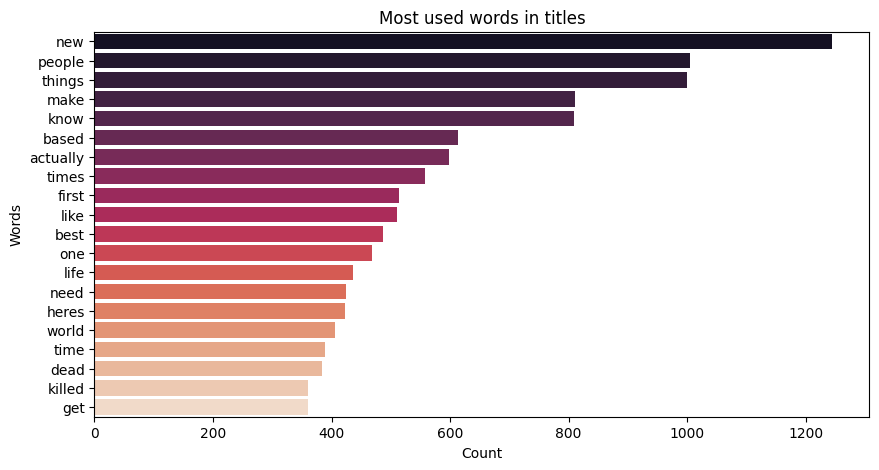

In [8]:
plot_most_used_words(df)

In [98]:
def plot_wordcloud(df, max_words = 200, max_font_size = 40):

    plt.figure(figsize=(20, 20))
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        scale=3,
        random_state=1).generate(str(df['title']))
    plt.imshow(wordcloud)
    plt.axis('off')

In [ ]:
# full data
plot_wordcloud(df)

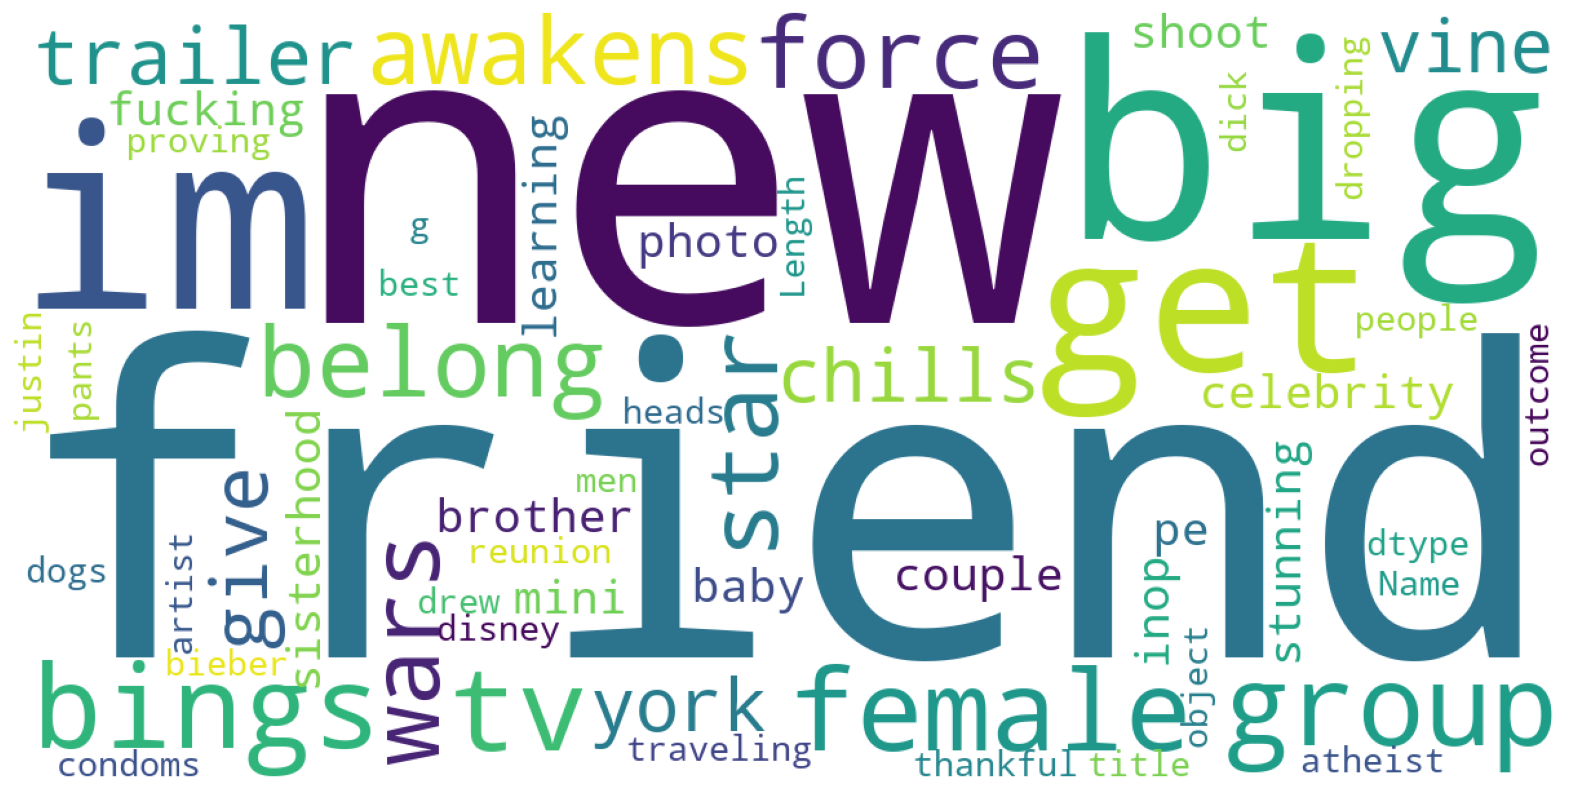

In [12]:
# positive data
plot_wordcloud(df[df['label'] == 1])

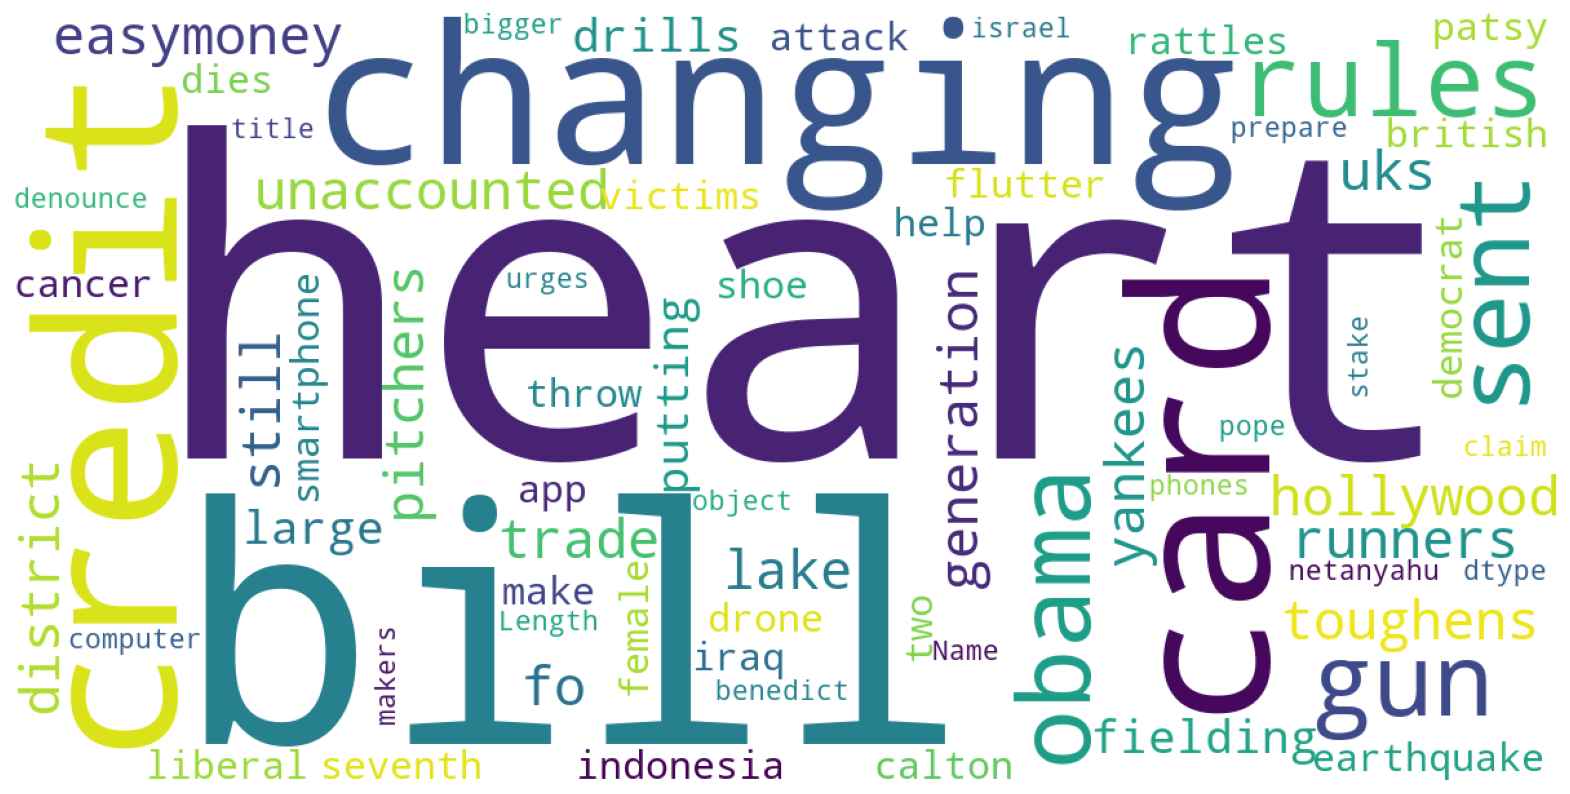

In [14]:
# negative data
plot_wordcloud(df[df['label'] == 0])

c:\Users\ISSAM ECH-CHAOUI\anaconda3\envs\envgpu\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


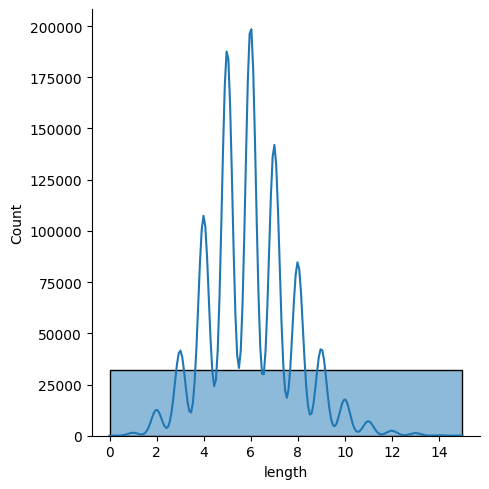

In [8]:
# write the code of plot the distribution of the length of the title with seaborn

def plot_distribution_length(df):
    import seaborn as sns
    sns.displot(df['length'], kde=True, bins=True)
    plt.show()

plot_distribution_length(df)

In [13]:
import pandas as pd
from utils.functions import *
df = pd.read_csv('../data/data.csv')

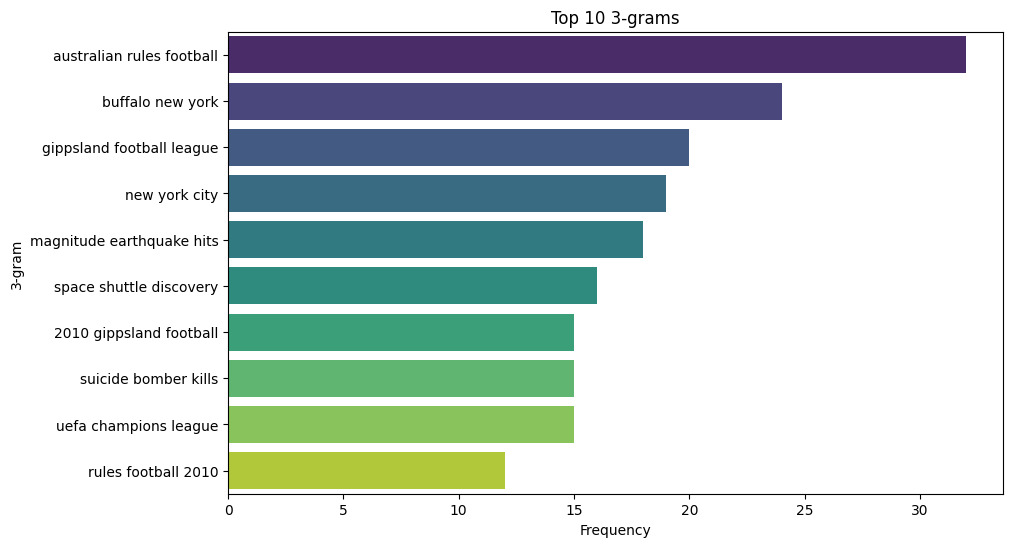

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
plot_most_frequent_ngrams(df[df['label'] == 0],n=3, num_ngrams=10)

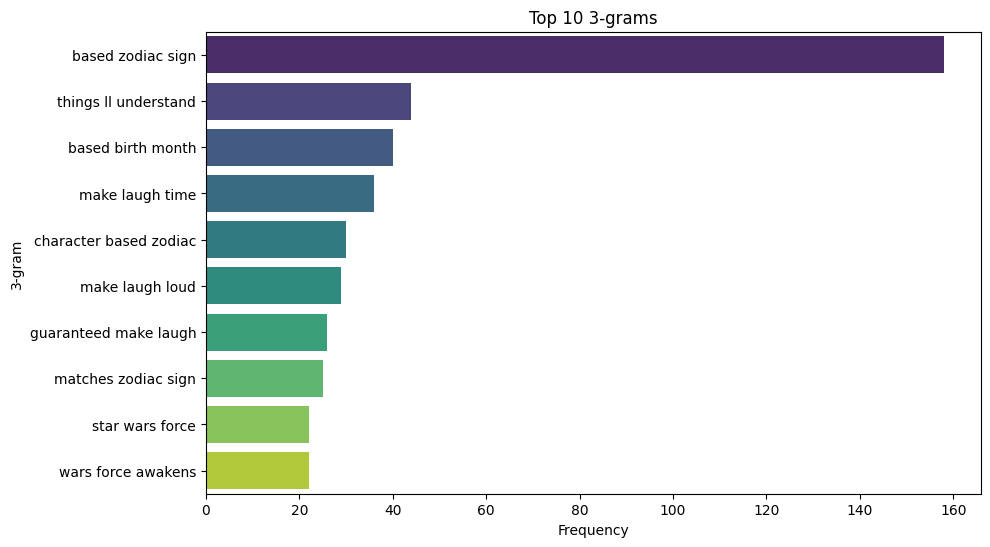

In [15]:
plot_most_frequent_ngrams(df[df['label'] == 1],  n=3, num_ngrams=10)

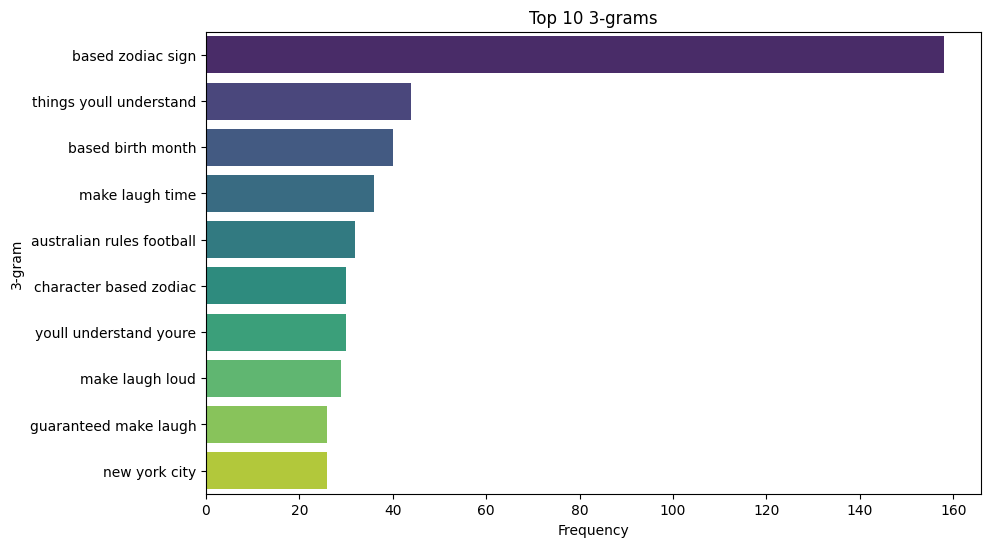

In [16]:
plot_most_frequent_ngrams(df, 'title', n=3, num_ngrams=10)

 *    Noun (NN)- Joseph, London, table, cat, teacher, pen, city

*    Verb (VB)- read, speak, run, eat, play, live, walk, have, like, are, is

*    Adjective (JJ)- beautiful, happy, sad, young, fun, three

*    Adverb (RB)- slowly, quietly, very, always, never, too, well, tomorrow

*    Preposition (IN)- at, on, in, from, with, near, between, about, under

*    Conjunction (CC)- and, or, but, because, so, yet, unless, since, if

*    Pronoun (PRP)- I, you, we, they, he, she, it, me, us, them, him, her, this

*    Interjection (INT)- Ouch! Wow! Great! Help! Oh! Hey! Hi!

# Model

Algorithm and methods (One-Hot encoding, TF-IDF, TF-IDF n-grams, TF-IDF char n-grams and word embeddings)

#### One-Hot encoding

#### using tf-idf n-grams


In [128]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
# tf-idf for 3-grams
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(ngram_range=(3, 3))
tfidf_vectorizer.fit(df['title'])
X = tfidf_vectorizer.transform(df['title']).toarray()  # Convert SparseTensor to dense array
y = df['label']

# split the data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# train a neural network model using tensorflow 
# define the model
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# train the model
model.fit(X_train, y_train, epochs=5, batch_size=32)

# evaluate the model
model.evaluate(X_test, y_test)

#### using tf-idf

In [ ]:
# doing tfidf
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df['title'])
df_tfidf = pd.DataFrame(X.toarray(), columns=tfidf.get_feature_names_out())


In [29]:
# train the deep learning model with the tfidf

import numpy as np
# Convert input data to numpy arrays
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

model = Sequential()
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), verbose=1)

Epoch 1/10
800/800 [==============================] - 36s 41ms/step - loss: 0.1894 - accuracy: 0.9535 - val_loss: 0.0710 - val_accuracy: 0.9758
Epoch 2/10
800/800 [==============================] - 31s 39ms/step - loss: 0.0421 - accuracy: 0.9868 - val_loss: 0.0601 - val_accuracy: 0.9784
Epoch 3/10
800/800 [==============================] - 27s 34ms/step - loss: 0.0204 - accuracy: 0.9946 - val_loss: 0.0605 - val_accuracy: 0.9786
Epoch 4/10
800/800 [==============================] - 27s 34ms/step - loss: 0.0102 - accuracy: 0.9977 - val_loss: 0.0635 - val_accuracy: 0.9772
Epoch 5/10
800/800 [==============================] - 26s 33ms/step - loss: 0.0056 - accuracy: 0.9990 - val_loss: 0.0686 - val_accuracy: 0.9775
Epoch 6/10
800/800 [==============================] - 26s 33ms/step - loss: 0.0031 - accuracy: 0.9995 - val_loss: 0.0709 - val_accuracy: 0.9781
Epoch 7/10
800/800 [==============================] - 27s 33ms/step - loss: 0.0020 - accuracy: 0.9996 - val_loss: 0.0758 - val_accuracy:

#### using the embedding layer

embedding layer -> Turns positive integers (indexes) into dense vectors of fixed size.

e.g. [[4], [20]] -> [[0.25, 0.1], [0.6, -0.2]]


1. **Sequences** : `texts_to_sequences` prend une liste de titres des articles et convertit chaque texte en une séquence d'entiers. Chaque entier représente un mot unique dans le vocabulaire.

2. **Padding** : Les `padded_sequences` sont créées en utilisant la méthode `pad_sequences` prend les séquences créées à l'étape précédente et les remplit jusqu'à une longueur fixe. Dans ce cas, la `max_length` est fixée à 12, donc toute séquence de moins de 12 mots sera complétée par des zéros à la fin, et toute séquence de plus de 12 mots sera tronquée. 


La couche d'embedding est utilisée pour représenter les mots de manière plus significative pour le modèle. 

Voici comment cela fonctionne :

1. **Initialisation** : la couche d'embedding crée une matrice de poids où chaque ligne représente un mot du vocabulaire et chaque colonne représente une dimension de l'espace d'embedding. Les poids sont initialisés avec de petites valeurs aléatoires.

2. **Transformation des mots en vecteurs** : chaque mot est représenté par un vecteur unique dans l'espace d'embedding. 

3. **Apprentissage** : Pendant l'entraînement du modèle, les poids de la matrice d'embedding sont ajustés pour minimiser la fonction de perte. 

In [ ]:
train_sequences

In [109]:
# split the data into train, test and validation
X_train, X_test, y_train, y_test = train_test_split(df['title'], df['label'], test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=1)

# create a tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train) #tokenizer.fit_on_texts(df['title'])
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
print('Vocabulary size: {}'.format(vocab_size))

# create sequences
train_sequences = tokenizer.texts_to_sequences(X_train) # list of list of int
test_sequences = tokenizer.texts_to_sequences(X_test)
val_sequences = tokenizer.texts_to_sequences(X_val)

# padding sequences
max_length = 15 # max length of each sequences
embedding_dim = 16 # dimension of the embedding vector

train_padded_sequences = pad_sequences(train_sequences, maxlen=max_length, padding='post')  # list of list of int
test_padded_sequences = pad_sequences(test_sequences, maxlen=max_length, padding='post')  # list of list of int
val_padded_sequences = pad_sequences(val_sequences, maxlen=max_length, padding='post')  # list of list of int

# Create the model
model = Sequential() # create a sequential model
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length)) # add an embedding layer,

model.add(Bidirectional(LSTM(32))) # add a bidirectional LSTM layer

model.add(Dense(24, activation='relu')) # add a dense layer

model.add(Dropout(0.5)) # add a dropout layer

model.add(Dense(1, activation='sigmoid')) # add a dense layer

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # compile the model
model.summary()

# train the model
num_epochs = 1
history = model.fit(train_padded_sequences, y_train, validation_data=(val_padded_sequences, y_val)
                    ,epochs=num_epochs)

Vocabulary size: 21459
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 15, 16)            343344    
                                                                 
 bidirectional_4 (Bidirectio  (None, 64)               12544     
 nal)                                                            
                                                                 
 dense_8 (Dense)             (None, 24)                1560      
                                                                 
 dropout_4 (Dropout)         (None, 24)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 25        
                                                                 
Total params: 357,473
Trainable params: 357,473
Non-trainable params: 0
_________________________

In [110]:
model.evaluate(test_padded_sequences, y_test)

100/100 [==============================] - 0s 3ms/step - loss: 0.1086 - accuracy: 0.9597


[0.10856765508651733, 0.9596874713897705]

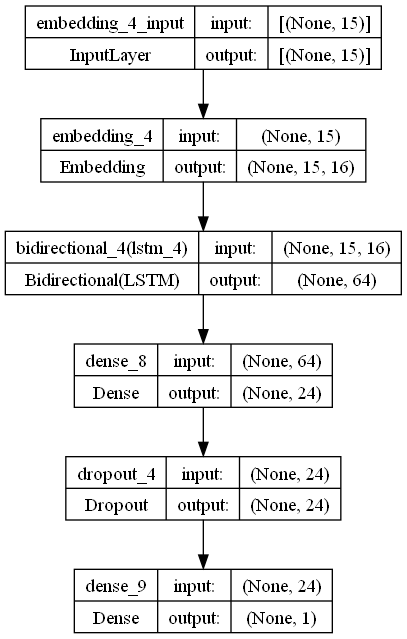

In [111]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96)      

In [112]:
# see the sequences
print(train_sequences)

[[1178, 3309, 11261, 865, 143, 11262, 573, 199], [316, 77, 1415], [289, 48, 1085, 323, 11263, 420, 2, 4052, 4053], [357, 2124, 3027, 112, 4054, 749, 4055, 5405], [324, 1779, 1494, 1687, 8100, 8101, 1583, 1584, 1495, 5406], [80, 3310, 97, 155, 809, 11264, 5407], [28, 347, 1585, 1132, 656, 2433, 4648, 11265, 2125], [3311, 11266, 3650, 1586, 5408], [670, 40, 5, 1292, 268], [3312, 3651, 11267, 57, 1688, 962], [246, 2798, 4056, 4649, 8102, 11268, 143], [182, 1179, 11269, 4057, 308, 421], [3, 4058, 1994, 632, 2434], [15, 34, 963, 5409, 50, 66, 770], [3313, 43, 501], [135, 696, 35, 71], [932, 5410, 794, 2265, 1038], [4650, 271, 13, 289, 11270, 156, 4059, 11271], [2799, 337, 612, 3652], [192, 149, 11272, 502], [671, 21, 964, 1780, 1587], [65, 29, 3028, 4651], [15, 392, 2612, 297, 557, 4652, 11, 588, 131, 5411], [3, 6454, 251, 4060], [9, 309, 3310, 8103, 13, 40, 3314], [8104, 1588, 1884, 121, 1039], [5412, 588, 795, 105], [272, 74, 3653, 11273, 11274, 317, 19, 888], [2266, 16, 90, 59], [44, 465

In [113]:
# see the padded sequences
print(train_padded_sequences)

[[ 1178  3309 11261 ...     0     0     0]
 [  316    77  1415 ...     0     0     0]
 [  289    48  1085 ...     0     0     0]
 ...
 [   44  3257  2588 ...     0     0     0]
 [  103  1852    24 ...     0     0     0]
 [   53    20  1159 ...     0     0     0]]


In [114]:
# Get the embeddings
embeddings = model.layers[0].get_weights()[0]

In [119]:
embeddings.shape

(21459, 16)

In [118]:
embeddings[0]

array([ 0.0206025 , -0.00462773,  0.05874657,  0.0082799 , -0.02165372,
        0.0487874 , -0.05592593,  0.00081609, -0.04553382,  0.001259  ,
        0.00502351, -0.00877709,  0.00389513, -0.02839121,  0.00660412,
        0.04158061], dtype=float32)

In [76]:
len(word_index)

21458

In [80]:
#delete the last embedding 
embeddings = np.delete(embeddings, 0, axis=0)

In [81]:
embeddings.shape

(21458, 16)

In [88]:
# Write out the embeddings to a file
with open('embeddings.tsv', 'w') as f:
    for word, vec in zip(word_index.keys(), embeddings):
        f.write(word + "\t" + '\t'.join([str(x) for x in vec]) + "\n")

# Write out the labels (words) to a file
with open('meta.tsv', 'w') as f:
    for word in word_index.keys():
        f.write(word + "\n")

# Web application using streamlit

In [20]:
# save the model to use in the web app
model.save('model.h5')

# load the model
from tensorflow.keras.models import load_model
model = load_model('model.h5')

# save the tokenizer
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# load the tokenizer
import pickle
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)


In [35]:
# When the input changes, the cached model will be used
text = st.text_input("Enter some text", value="Classify this")
if text:
    new_title = ['issa,']
    new_sequences = tokenizer.texts_to_sequences(new_title)
    new_padded_sequences = pad_sequences(new_sequences, maxlen=max_length, padding='post')
    output = model.predict(new_padded_sequences)
    st.write("Prediction: ", output)

# show the web app using this notebook
# !streamlit run app.py

2024-01-03 17:34:10.076 
  command:

    streamlit run c:\Users\ISSAM ECH-CHAOUI\anaconda3\envs\envgpu\lib\site-packages\ipykernel_launcher.py [ARGUMENTS]


1/1 [==============================] - 1s 610ms/step


In [38]:
output[0][0]

0.55813557